In [1]:
# DM Halo Remnant - Density Profile/Shape
# Research Assignment 5
# Ryan Lewis
# ASTR 400B

In [2]:
# Questions to be addressed are:
    # What is the final density profile? Is it well fit by a Hernquist profile? 
    # Is it more or less concentrated than the MW or M31 before they merged?
    #
    # What is the distribution of dark matter particles from the M31 vs the MW?

# The first question will be the primary focus of this project.

In [3]:
# DM Halo Remnant - Density Profile/Shape Description:
#
# 1:
# In addressing the first question, the final and first density profiles will be analyzed. 
# The final profile of the MW and M31 (and the combination of the two) will be compared to a 
# Hernquist (1990) profile and a Navarro Frenk White (1995) profile.
# If time allows, the Einasto (1965) profile will be added as well.
#
# The Hernquist density profile is given by ρ(r) = ρs*r**2/(a+r)**2 
# where ρs is the characteristic density, a is the scale radius, and r is the distance from the galactic center
#
# The NFW density profile is given by ρ(r) = ρs/((r/a)*(1+(r/a))**2)
# where a is the scale radius, r is the distance from the galactic center, and ρs is the characteristic density
#
# The Einasto profile is given by ρ(r) = ρs*Exp{-dn[(r/a)**(1/n)-1]}
# where dn is a numerical constant that ensures a is the half-mass radius and n is the Einasto index
#
# The profiles for each galaxy will be plotted on a mass vs. radius diagram
#
# All profiles will be compared using a least chi-squared fitting. The errors of each profile will then be 
# stated, providing a comparison measurement between the density profiles.
# The profiles will then be plotted in three dimensions, each with a color map depicting the difference between 
# the measured data and the predicted density
#
# The concentration of both the MW and M31 (and the combination of the two?) dark matter halos will be compared
# between their first and last frames.
#
# The concentration is defined as K = R200/a
# where a is the scale length of the hernquist halo, and R200 is the radius where the halo density is 200 times 
# the cirtical density needed to close the universe (ρ_crit = 1.62e11 Msun/Mpc**3)
#
# Should the snapshot at which one of the halos best fit the Hernquist profile want to be found, a least 
# chi-squared method could be used in analyzing each snapshot. If time allows, this may be pursued.
#
#---------------------------------------------------------------------------------------------------------------
#
# 2:
# In exploring the second question, the 2D histograms of MW and M31 (and the combination of the two) will be 
# plotted at the first, last, and middle snapshots. This will be done in the following way:
    # Import data from first, last, and middle snapshots 
    # Align the angular momentum vector of the halos in the postive z-direction (RotateFrame in Lab 7)
    # Using 2D Histograms, create a plot of the halo density of M31 and MW (and both M31 and MW for each 
    # snapshot?) (Part A in Lab 7)

In [4]:
# Import modules
import numpy as np
import scipy.stats
import astropy.units as u
from astropy.constants import G

# Import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

# Import personal modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile

In [5]:
# Code for plotting contours - Copied from Lab7
# from https://gist.github.com/adrn/3993992

import scipy.optimize as so

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    fmt = {}
    
    
    # Contour Levels Definitions
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
    
    # You might need to add a few levels
    one_sigma1 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.80))
    one_sigma2 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.90))

    # Array of Contour levels. Adjust according to the above
    levels = [one_sigma, one_sigma1, one_sigma2, two_sigma, three_sigma][::-1]
    
    # contour level labels  Adjust accoding to the above.
    strs = ['0.68','0.8', '0.9', '0.95', '0.99'][::-1]

    
    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)
    
    return contour

In [6]:
# Create a Center of Mass Object for M31 and MW
COMMW = CenterOfMass("MW_000.txt",1)
COMM31 = CenterOfMass("M31_000.txt",1)

In [7]:
# Compute COM of M31 using halo particles
COMP_M31 = COMM31.COM_P(0.1)
COMV_M31 = COMM31.COM_V(COMP_M31[0],COMP_M31[1],COMP_M31[2])

# Compute COM of MW using halo particles
COMP_MW = COMMW.COM_P(0.1)
COMV_MW = COMMW.COM_V(COMP_MW[0],COMP_MW[1],COMP_MW[2])

In [8]:
# Determine positions of M31 halo particles relative to COM 
xH_M31 = COMM31.x - COMP_M31[0].value 
yH_M31 = COMM31.y - COMP_M31[1].value 
zH_M31 = COMM31.z - COMP_M31[2].value 

# Calculate the total magnitude of M31
rtot_M31 = np.sqrt(xH_M31**2 + yH_M31**2 + zH_M31**2)

# Determine velocities of halo particles relative to COM motion
vxH_M31 = COMM31.vx - COMV_M31[0].value 
vyH_M31 = COMM31.vy - COMV_M31[1].value 
vzH_M31 = COMM31.vz - COMV_M31[2].value 

# total velocity 
vtot_M31 = np.sqrt(vxH_M31**2 + vyH_M31**2 + vzH_M31**2)

# Vectors for r and v 
r_M31 = np.array([xH_M31,yH_M31,zH_M31]).T # transposed 
v_M31 = np.array([vxH_M31,vyH_M31,vzH_M31]).T

In [9]:
# Determine positions of MW halo particles relative to COM 
xH_MW = COMMW.x - COMP_MW[0].value 
yH_MW = COMMW.y - COMP_MW[1].value 
zH_MW = COMMW.z - COMP_MW[2].value 

# Calculate the total magnitude of MW
rtot_MW = np.sqrt(xH_MW**2 + yH_MW**2 + zH_MW**2)

# Determine velocities of halo particles relative to COM motion
vxH_MW = COMMW.vx - COMV_MW[0].value 
vyH_MW = COMMW.vy - COMV_MW[1].value 
vzH_MW = COMMW.vz - COMV_MW[2].value 

# total velocity 
vtot_MW = np.sqrt(vxH_MW**2 + vyH_MW**2 + vzH_MW**2)

# Vectors for r and v 
r_MW = np.array([xH_MW,yH_MW,zH_MW]).T # transposed 
v_MW = np.array([vxH_MW,vyH_MW,vzH_MW]).T

In [10]:
# Rotate Frame - Copied from Lab7
# A function that will rotate the position and velocity vectors so that the halo angular momentum is aligned with z axis. 

def RotateFrame(posI,velI):
    # Input:  3D array of positions and velocities
    # Output: 3D array of rotated positions and velocities such that j is in z direction

    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel

In [11]:
# Determine the rotated velocity vectors
rnew_M31, vnew_M31 = RotateFrame(r_M31, v_M31) # M31
rnew_MW, vnew_MW = RotateFrame(r_MW, v_MW) # MW

Text(0.5, 1.0, 'M31 Initial Density Profile - Edge On')

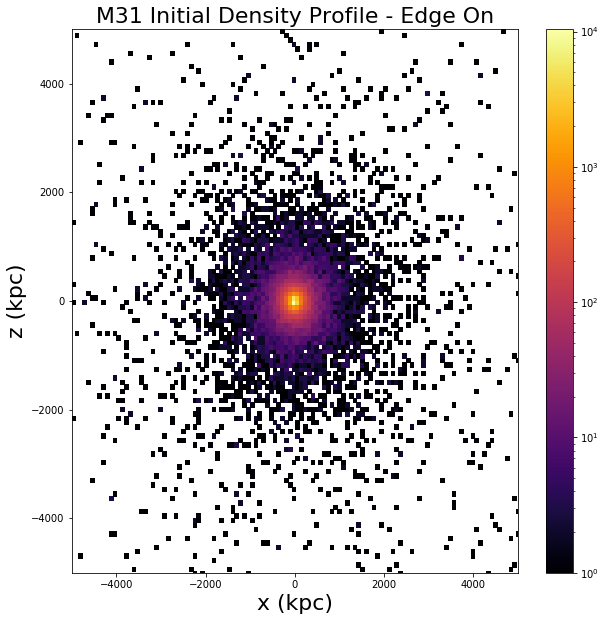

In [12]:
# Rotated M31 Halo - EDGE ON at Snap 0

# M31 Halo Density 
fig, ax= plt.subplots(figsize=(10, 10))

# plot the particle density for M31 , 2D histogram
plt.hist2d(rnew_M31[:, 0], rnew_M31[:, 2], bins = 250, norm = LogNorm(), cmap='inferno')

plt.colorbar()

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('z (kpc)', fontsize=22)

#set axis limits
plt.ylim(-5000,5000)
plt.xlim(-5000,5000)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Add title
plt.title('M31 Initial Density Profile - Edge On', fontsize=22, loc='center', pad=None)

Text(0.5, 1.0, 'M31 Initial Density Profile - Face On')

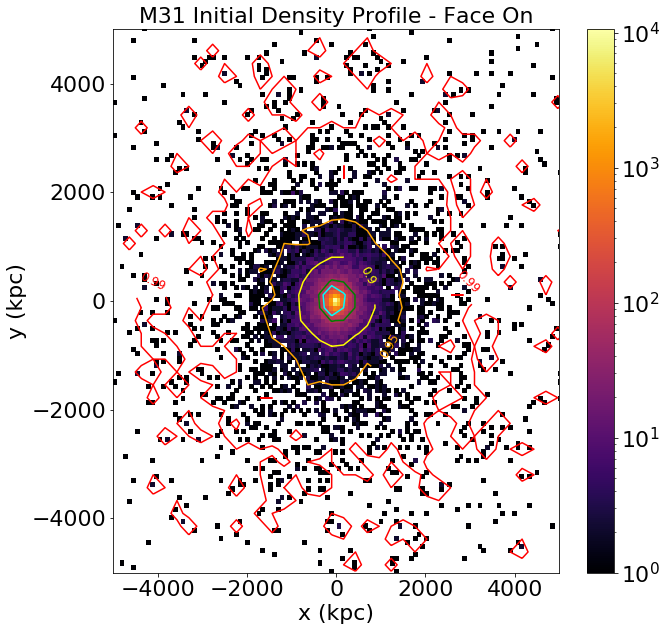

In [13]:
# Rotated M31 Halo - FACE ON at Snap 0

# M31 Halo Density 
fig, ax= plt.subplots(figsize=(10, 10))

# plot the particle density for M31 
plt.hist2d(rnew_M31[:, 0], rnew_M31[:, 1], bins = 250, norm = LogNorm(), cmap='inferno')
plt.colorbar()

# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.
density_contour(rnew_M31[:, 0], rnew_M31[:, 1], 80, 80, ax=ax, colors=['red', 'orange', 'yellow', 'green', 'cyan'])

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)

#set axis limits
plt.ylim(-5000,5000)
plt.xlim(-5000,5000)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Add title
plt.title('M31 Initial Density Profile - Face On', fontsize=22, loc='center', pad=None)

In [14]:
# Could add Part C from Lab7, where particle velocities are visulaized and examined (Not sure if helpful at all)

Text(0.5, 1.0, 'MW Initial Density Profile - Edge On')

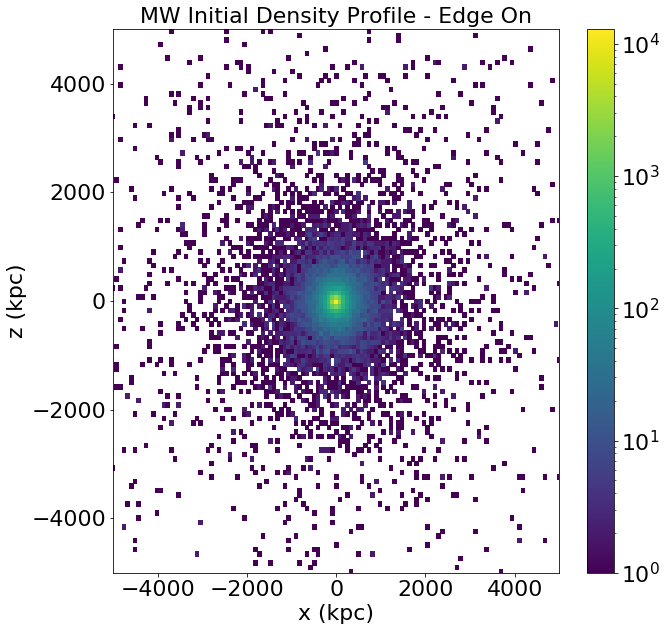

In [15]:
# Rotated MW Halo - EDGE ON at Snap 0

# MW Halo Density 
fig, ax= plt.subplots(figsize=(10, 10))

# plot the particle density for MW , 2D histogram
plt.hist2d(rnew_MW[:, 0], rnew_MW[:, 2], bins = 250, norm = LogNorm(), cmap='viridis')

plt.colorbar()

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('z (kpc)', fontsize=22)

#set axis limits
plt.ylim(-5000,5000)
plt.xlim(-5000,5000)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Add title
plt.title('MW Initial Density Profile - Edge On', fontsize=22, loc='center', pad=None)

Text(0.5, 1.0, 'MW Initial Density Profile - Face On')

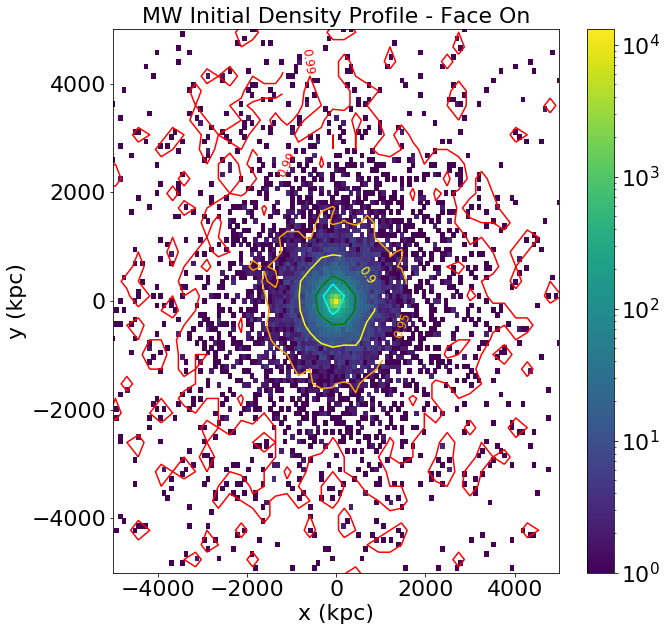

In [16]:
# Rotated MW Halo - FACE ON

# M31 Halo Density 
fig, ax= plt.subplots(figsize=(10, 10))

# plot the particle density for M31 
plt.hist2d(rnew_MW[:, 0], rnew_MW[:, 1], bins = 250, norm = LogNorm(), cmap='viridis')
plt.colorbar()

# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.
density_contour(rnew_MW[:, 0], rnew_MW[:, 1], 80, 80, ax=ax, colors=['red', 'orange', 'yellow', 'green', 'cyan'])

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)

#set axis limits
plt.ylim(-5000,5000)
plt.xlim(-5000,5000)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Add title
plt.title('MW Initial Density Profile - Face On', fontsize=22, loc='center', pad=None)

In [24]:
M31 = MassProfile("M31", 0)
MW = MassProfile("MW", 0)

Text(0.15, 0.83, 'M31 Mass Profile')

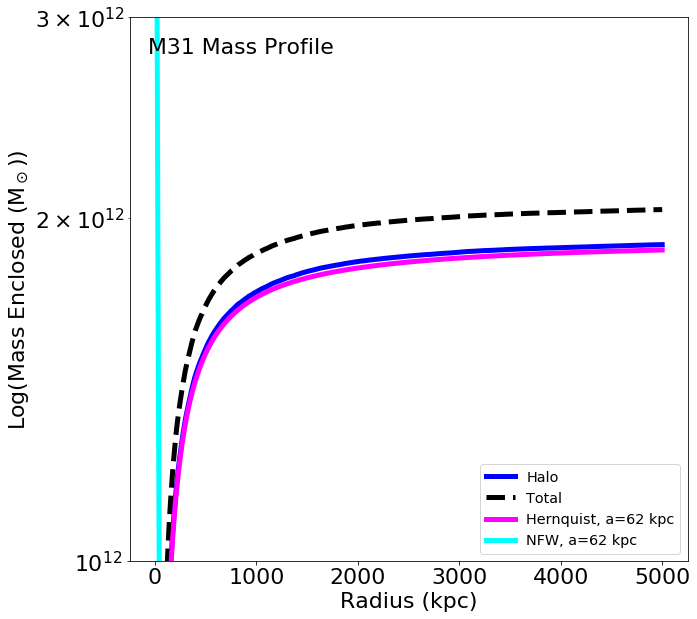

In [25]:
# Plot the Mass Profile for the M31.
Renc = np.arange(0.1,5000.1,1)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot mass enclosed for Halo 
plt.semilogy(Renc,M31.MassEnclosed(1,Renc), color='blue', linewidth=5, label='Halo')

# TOTAL Mass
plt.semilogy(Renc,M31.MassEnclosedTotal(Renc), color='black', linestyle="--",linewidth=5, label='Total')

# Hernquist Profile
plt.semilogy(Renc,M31.HernquistMass(Renc,62,1.921e12), color='magenta',linewidth=5, label='Hernquist, a=62 kpc')

# NFW Profile
plt.semilogy(Renc,M31.NFWMass(Renc,62,1.921e12), color='cyan',linewidth=5, label='NFW, a=62 kpc')

# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel(r'Log(Mass Enclosed (M$_\odot$))', fontsize=22)

# set axis limits
plt.ylim(1e12,3e12)

# adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# add figure text
plt.figtext(0.15, 0.83, 'M31 Initial Mass Profile', fontsize=22)

In [26]:
MW_I = MassProfile("MW", 0) # Initialize the MassProfile class for MW at first Snapshot
MW_M = MassProfile("MW", 400) # Initialize the MassProfile class for MW at middle Snapshot
MW_F = MassProfile("MW", 801) # Initialize the MassProfile class for MW at last Snapshot

M31_I = MassProfile("M31", 0) # Initialize the MassProfile class for M31 at first Snapshot
M31_M = MassProfile("M31", 400) # Initialize the MassProfile class for M31 at middle Snapshot
M31_F = MassProfile("M31", 801) # Initialize the MassProfile class for M31 at last Snapshot

In [48]:
# Measure discrepencies between data and mass profiles

# Degrees of Freedom
# DOF = (len(Renc)-1)*(2-1)

# M31 Hernquist Chi Squared
χH_M31_I, pH_M31_I = scipy.stats.chisquare(M31_I.MassEnclosed(1,Renc), M31_I.HernquistMass(Renc,62,1.921e12), 599)
χH_M31_M, pH_M31_M = scipy.stats.chisquare(M31_M.MassEnclosed(1,Renc), M31_M.HernquistMass(Renc,62,1.921e12))
χH_M31_F, pH_M31_F = scipy.stats.chisquare(M31_F.MassEnclosed(1,Renc), M31_F.HernquistMass(Renc,62,1.921e12))

# M31 NFW Chi Squared
χNFW_M31_I, pNFW_M31_I = scipy.stats.chisquare(M31_I.MassEnclosed(1,Renc), M31_I.NFWMass(Renc,62,1.921e12))
χNFW_M31_M, pNFW_M31_M= scipy.stats.chisquare(M31_M.MassEnclosed(1,Renc), M31_M.NFWMass(Renc,62,1.921e12))
χNFW_M31_F, pNFW_M31_F = scipy.stats.chisquare(M31_F.MassEnclosed(1,Renc), M31_F.NFWMass(Renc,62,1.921e12))

# MW Hernquist Chi Squared
χH_MW_I, pH_MW_I = scipy.stats.chisquare(MW_I.MassEnclosed(1,Renc), MW_I.HernquistMass(Renc,61,1.975e12))
χH_MW_M, pH_MW_M = scipy.stats.chisquare(MW_M.MassEnclosed(1,Renc), MW_M.HernquistMass(Renc,61,1.975e12))
χH_MW_F, pH_MW_F = scipy.stats.chisquare(MW_F.MassEnclosed(1,Renc), MW_F.HernquistMass(Renc,61,1.975e12))

# MW NFW Chi Squared
χNFW_MW_I, pNFW_MW_I = scipy.stats.chisquare(MW_I.MassEnclosed(1,Renc), MW_I.NFWMass(Renc,61,1.975e12))
χNFW_MW_M, pNFW_MW_M = scipy.stats.chisquare(MW_M.MassEnclosed(1,Renc), MW_M.NFWMass(Renc,61,1.975e12))
χNFW_MW_F, pNFW_MW_F = scipy.stats.chisquare(MW_F.MassEnclosed(1,Renc), MW_F.NFWMass(Renc,61,1.975e12))

pH_M31_I

0.0

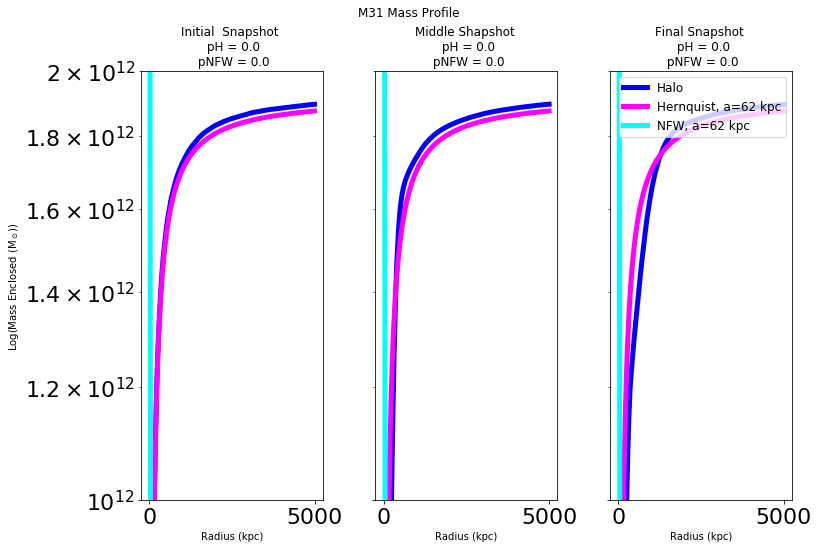

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(12,8))
fig.suptitle('M31 Mass Profile') # Add title

# Hernquist and NFW Profiles at Snap 0
axs[0].semilogy(Renc,M31_I.MassEnclosed(1,Renc), color='blue', linewidth=5, label='Halo')
axs[0].semilogy(Renc,M31_I.HernquistMass(Renc,62,1.921e12), color='magenta',linewidth=5, label='Hernquist, a=62 kpc')
axs[0].semilogy(Renc,M31_I.NFWMass(Renc,62,1.921e12), color='cyan',linewidth=5, label='NFW, a=62 kpc')
axs[0].set_title('Initial  Snapshot \n pH = ' + str(pH_M31_I) + '\n pNFW = ' + str(pNFW_M31_I))

# Hernquist and NFW Profiles at Snap 400
axs[1].semilogy(Renc,M31_M.MassEnclosed(1,Renc), color='blue', linewidth=5, label='Halo')
axs[1].semilogy(Renc,M31_M.HernquistMass(Renc,62,1.921e12), color='magenta',linewidth=5, label='Hernquist, a=62 kpc')
axs[1].semilogy(Renc,M31_M.NFWMass(Renc,62,1.921e12), color='cyan',linewidth=5, label='NFW, a=62 kpc')
axs[1].set_title('Middle Shapshot \n pH = ' + str(pH_M31_M) + '\n pNFW = ' + str(pNFW_M31_M))

# Hernquist and NFW Profiles at Snap 801
axs[2].semilogy(Renc,M31_F.MassEnclosed(1,Renc), color='blue', linewidth=5, label='Halo')
axs[2].semilogy(Renc,M31_F.HernquistMass(Renc,62,1.921e12), color='magenta',linewidth=5, label='Hernquist, a=62 kpc')
axs[2].semilogy(Renc,M31_F.NFWMass(Renc,62,1.921e12), color='cyan',linewidth=5, label='NFW, a=62 kpc')
axs[2].set_title('Final Snapshot \n pH = ' + str(pH_M31_F) + '\n pNFW = ' + str(pNFW_M31_F))

axs[0].set_ylim([1E12, 2E12])
axs[1].set_ylim([1E12, 2E12])
axs[2].set_ylim([1E12, 2E12])

# Add axis labels
for ax in axs.flat:
    ax.set(xlabel='Radius (kpc)', ylabel=r'Log(Mass Enclosed (M$_\odot$))')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.tight_layout(pad=3.0)

# Add a legend
legend = plt.legend(loc='lower right',fontsize='large')

Text(0.15, 0.83, 'Milky Way Mass Profile')

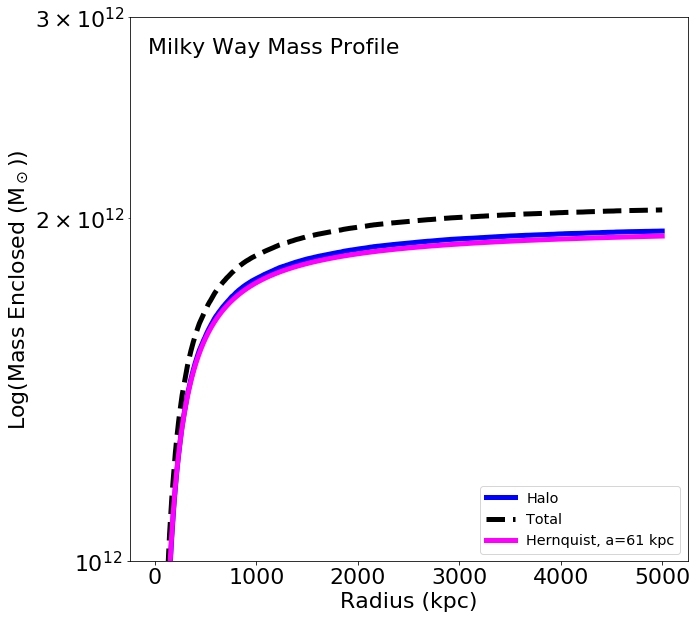

In [23]:
# Plot the Mass Profile for the MW.
Renc = np.arange(0.1,5000.1,1)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot mass enclosed for Halo 
plt.semilogy(Renc,MW.MassEnclosed(1,Renc), color='blue', linewidth=5, label='Halo')

# TOTAL Mass
plt.semilogy(Renc,MW.MassEnclosedTotal(Renc), color='black', linestyle="--",linewidth=5, label='Total')

# Hernquist Profile
plt.semilogy(Renc,MW.HernquistMass(Renc,61,1.975e12), color='magenta',linewidth=5, label='Hernquist, a=61 kpc')


# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel(r'Log(Mass Enclosed (M$_\odot$))', fontsize=22)

#set axis limits
plt.ylim(1e12,3e12)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

#add figure text
plt.figtext(0.15, 0.83, 'Milky Way Mass Profile', fontsize=22)

In [19]:
# Make a contour plot of the Hernquist Density Profile for M31 and MW, both Edge and Face-On
# Compare to above contour plots of M31 and MW


In [20]:
# Plot the differences between the Hernquist and density profiles for M31 and MW

In [21]:
# Plot the difference between the densities of the M31 and MW Halos